In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt

In [12]:
class Model:
    def __init__(self,track_day = 5):
        self.m = 100 # 地圖大小 m*m 
        
        self.people_ratio = 2 # 地圖大小和人的數量比例
        
        self.D = 10 # 狀態更新到10視為死亡
        
        self.track_day = track_day # 向前追朔幾天
        
        self.ratio_medical_people = 15 # 醫療人員和總人口的比例

        self.cure = 0.4 # 送到醫院時，能夠將治癒能力數值 - 0.4，治癒能力數值表示每回合可以打多少折，越低越好

        self.threshold_detect = 2 # 較能被檢測出的病毒含量
        self.threshold_o = 2.5 # 產生明顯病徵的病毒含量，同時也視為已確診的病毒含量

        self.k = 1.5 # 影響傳染力方程式的斜率
        self.b = 0 # 影響傳染力方程式的截距
        
        # 紀錄醫療能量用
        self.medical_capacity = [] # 每回合的醫療能量
        self.at_isolated = [] # 每回合被隔離的人數
        self.at_hospital =[] # 每回合住院的人數
        
        self.candicate = [] # 被檢測出為 positive的人，每回合會被清空
        
        
        self.P_py = 0.95
        self.P_nn = 0.95
        self.false_positive = [] # 紀錄 false positive 的人

        
    def compile(self):
        
        self.map = np.zeros((self.m , self.m)) #生成地圖
        
        self.N = self.m * self.m // self.people_ratio # 總人口 = 地圖面積 / self.people_ratio
        
        self.people = np.zeros((self.N,7)) # 人物資訊(0編號，1狀態，2行動能力，3治癒能力，4免疫，5該回合是否篩檢過，6是否隔離)
        
        self.__init_people() # 初始化人物資訊
        
        self.trajectory = np.random.randint(low = 0, high = self.m, size = (self.N,self.track_day,2)) # 紀錄軌跡
        
        self.hospital_c = max(250, self.N // self.ratio_medical_people) # 醫療容量
        
        print("track day = ", self.track_day)
        print("Number of people = ", self.N)
        print("Size of map = ", self.map.shape)
        print("Medical capacity = ", self.hospital_c)
        print("="*10)
        
        # 先讓每個人走幾步
        for i in range(self.track_day):
            self.__move()
            
        self.medical_capacity = []
        self.at_isolated = []
        self.at_hospital =[]
        
        

    def call(self):
        self.people[:,5] = np.zeros(self.N) #篩檢記錄更新
        self.update_state()
        self.__spread_region()
        self.__exam()
        self.__move()
    

    def __init_people(self):
        self.people[:,0] = np.arange(0,self.N) #編號
        self.people[:,1] = np.random.choice(a = [0.0,0.2,0.5], p = [0.9,0.05,0.05], size = self.N) #初始狀態
        self.people[:,2] = np.random.randint(1,3,size = self.N) #行動能力
        self.people[:,3] = np.random.normal(loc = 0.95, scale = 0.05, size = self.N) #治癒能力
        return None

    # 篩檢
    def __detect(self, val):
        P_py = self.P_py
        P_nn = self.P_nn
        if val >= self.threshold_detect:
            p = np.random.random()
            if p < P_py:
                return True
            else:
                return False
        else:
            p = np.random.random()
            if p < P_nn:
                return False
            else:
                return True
    
    # 產生[活著]及[非免疫]的那些人
    def __alive_potential(self):
        #活著
        mask1 = np.where((self.people[:,1]>=0) & (self.people[:,1]<self.D))
        mask1= mask1[0]
        
        
        # 非免疫
        mask2 = np.where(self.people[:,4]==0)
        mask2 = mask2[0]

        # 取交集

        mask = np.intersect1d(mask1,mask2)
        
        return mask
    
    def __alive_on_map_potential(self):
        #活著(alive)
        mask1 = np.where((self.people[:,1]>=0) & (self.people[:,1]<self.D))
        mask1= mask1[0]
        
        # 不在醫院且非隔離人員(on the map)
        mask2 = np.where(self.people[:,6]==0)
        mask2 = mask2[0]
        
        # 非免疫(potential)
        mask3 = np.where(self.people[:,4]==0)
        mask3 = mask3[0]

        # 取交集
        mask = np.intersect1d(mask1,mask2)
        mask = np.intersect1d(mask,mask3)
        
        return mask
    def __alive_on_map_potential_obv(self):
        '''
        出現病徵
        活著
        在地圖上
        非免疫
        '''
        mask1 = np. where((self.people[:,1]>=self.threshold_o) & 
                          (self.people[:,1]<self.D) & 
                          (self.people[:,6]==0) & 
                          (self.people[:,4]==0)
                         )
        mask2 = not mask1
        mask = mask1[0]
        return mask
    
    # 更新人物狀態
    def update_state(self):
        print("Step: update state")
        
        mask = self.__alive_potential()
        
        if mask.size == 0:
            return None
            
        for i in mask:

            #根據治癒能力改善或惡化狀態
            self.people[i,1] = self.people[i,1] * self.people[i,3]
            
            #若能改善到狀態<=0.5，視為康復，並且視為已經得過，獲得免疫。可能康復於隔離地，及地圖上
            if self.people[i,1] <= 0.5 and self.people[i,1] > 0 and self.people[i,3]<1:
                self.people[i,1] = 0.0
                self.people[i,4] = 1.0 # 獲得免疫
            
            #若state超過self.D，視為死亡，通常死在隔離地
            elif self.people[i,1] >= self.D:
                self.people[i,1] = self.D
                continue
            
            # 提出當下位置
            p = self.trajectory[i][-1]

            # 如果在醫院或是隔離，或是有免疫力，或是已經是帶原者了(避免自己繼續感染自己)，就沒有再被地圖感染的問題了
            if self.people[i,4] == 1 or self.people[i,6] != 0 or self.people[i,1]!=0:
                continue

            # 若非免疫則要根據當下地圖是否有致病力來更新本身狀態
            
            self.people[i,1] += self.map[p[0]][p[1]]
    

    # 傳染力方程式
    def __attack(self,state):
        return self.k * state - self.b

    def __spread_region(self):
        print("Step: spread_region")
        '''
        針對
        1.在地圖上
        2.還活著
        3.非免疫
        的人
        四周放入致病力
        '''

        # 刷新地圖，重新根據傳染力放上病毒
        self.map = np.zeros((self.m , self.m))

        mask = self.__alive_on_map_potential()
        
        if mask.size == 0:
            return None

        # 逐一放入致病力
        for i in mask:
            p = self.trajectory[i][-1] # 第i個人，當下位置
            self.__affect(index = i,row = p[0], col = p[1]) # 對其四周產生傳染力

    
    def __affect(self,index,row,col):
        '''
        給定人員後，將其四周3*3的範圍制入感染力
        若不同人重複影響同個區域，取最大值
        '''

        # 找左右邊界
        left = max(0,col-1)
        right = min(self.m-1,col+1)
        
        # 找上下邊界
        top = max(0,row-1)
        bottom = min(self.m-1,row+1)

        # 產生傳染力
        state = self.people[index,1]
        e = self.__attack(state)
        
        # 在地圖上放入傳染力
        for c in range(left,right+1):
            for r in range(top,bottom+1):
                self.map[r][c] = max(self.map[r][c],e)

    # 位置編碼，提升程式效能用
    def __pos_encoder(self,pos):
        shape_pos = pos.shape
        pos_encoded = []
        for i in range(shape_pos[0]):
            pos_encoded.append(pos[i][0]*self.m + pos[i][1])
        return np.array(pos_encoded)
    
    # 確認兩條路徑(a_arr,b_arr)是否有重疊
    def __is_intersect(self,a_arr,b_arr):
        intersect = np.intersect1d(a_arr,b_arr)
        if  intersect.size == 0:
            return False
        else:
            return True
    
    def __exam(self):
        print("Step: exam")
        self.candicate = [] # 待檢測名單
        
        mask = self.__alive_on_map_potential_obv()
        
        if mask.size ==0: 
            return None
        
        # 活著，表現出病徵，在地圖上，非免疫
        for i in mask:            
            if  self.__detect(self.people[i,1]):
                self.candicate.append(i)
            self.people[i,5] = 1 #更新篩檢狀態
        
        n = 0
        # 發佈陽性患者的路徑(肯定非醫院)
        while n < len(self.candicate):
            c = self.candicate[n]
            traj = self.trajectory[c]  # m*n-like array
            self.__track(traj) # 比對軌跡，將軌跡有重疊且驗出為陽性的人加入candicate
            n += 1 # 追蹤完一個人的軌跡
        
    def __track(self,traj_source):
        mask = np.where((self.people[:,1]<self.D) & 
                        (self.people[:,4] == 0) & 
                        (self.people[:,5] == 0) & 
                        (self.people[:,6] == 0)
                       )
        mask = mask[0]
        if mask.size ==0:
            return None
        
        for i in mask:
            tr_target = self.trajectory[i]
            pos_encoded_source = self.__pos_encoder(traj_source)
            pos_encoded_target = self.__pos_encoder(tr_target)
            if self.__is_intersect(pos_encoded_source,pos_encoded_target):
                self.people[i,5] = 1
                if self.__detect(self.people[i,1]):
                    self.candicate.append(i)
                    if self.people[i,1] < self.threshold_detect:
                        self.false_positive.append(i)

            
    def __move(self):
        '''
        根據自身能力在r*r的範圍內自由移動
        但不能超過地圖限制
        '''
        print("Step: move")
        if self.candicate:
            for i in self.candicate:
                if self.hospital_c > 0:
                    self.people[i,6] = 1.0
                    self.people[i,3] = max(0,self.people[i,3]-self.cure)
                    self.hospital_c -=1
                else:
                    self.people[i,6] = 0.5
        
        for i in range(self.N):

            if self.people[i,1]>=self.D:
                if self.people[i,6] == 1.0: 
                    self.hospital_c += 1
                self.people[i,6] = 0 # 死亡並非隔離
                continue
            
            # 在醫院或隔離地康復的人，隨機丟回地圖
            if self.people[i,6]!=0 and self.people[i,1]==0:
                if self.people[i,6] == 1.0:
                    self.hospital_c += 1
                self.people[i,6] = 0 # 隔離狀態變回0
                self.__put_to_map(i) # 丟回地圖
                continue
            
            # 在醫院或隔離地還沒康復的人，原地待著不要亂跑
            elif self.people[i,6] != 0 and self.people[i,1]!=0:
                continue
                
            # 在地圖上、活著、沒被檢測出陽性的人，根據自身能力移動位置
            
            p = self.trajectory[i][-1]
            row = p[0]
            col = p[1]
            r = self.people[i,2]
            move_r = np.random.randint(-r,r+1)
            move_c = np.random.randint(-r,r+1)
            next_r = row + move_r
            next_c = col + move_c
            if next_c < 0:
                next_c = 0
            if next_c > self.m-1:
                next_c = self.m-1
            if next_r < 0:
                next_r = 0
            if next_r > self.m-1:
                next_r = self.m-1
                
            next_pos = np.array([next_r,next_c])
            temp = self.trajectory[i].copy()
            self.trajectory[i,0:self.track_day-1] = temp[1:]
            self.trajectory[i,self.track_day-1] = next_pos
        
        
        self.medical_capacity.append(self.hospital_c)
        self.at_isolated.append(np.where(self.people[:,6] == 0.5)[0].size)
        self.at_hospital.append(np.where(self.people[:,6] == 1.0)[0].size)
            
    
    # 出院或解除隔離後，隨機丟到地圖上
    def __put_to_map(self,index):
        i = index
        r = np.random.randint(0,self.m)
        c = np.random.randint(0,self.m)
        
        next_pos = np.array([r,c])
        temp = self.trajectory[i].copy()
        self.trajectory[i,0:self.track_day-1] = temp[1:]
        self.trajectory[i,self.track_day-1] = next_pos
        return None

In [13]:
np.random.seed(123)
track_day = 5
model2 = Model(track_day = track_day)
model2.compile()
n_Days = 400


dead = []

for i in range(n_Days):
    
    print("\nDay: ",i)
    
    count_dead = model2.N - np.where(model2.people[:,1]<model2.D)[0].size
    dead.append(count_dead)

    model2.call()


track day =  5
Number of people =  5000
Size of map =  (100, 100)
Medical capacity =  333
Step: move
Step: move
Step: move
Step: move
Step: move

Day:  0
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  1
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  2
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  3
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  4
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  5
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  6
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  7
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  8
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  9
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  10
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  11
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  12
Ste

Step: update state
Step: spread_region
Step: exam
Step: move

Day:  116
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  117
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  118
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  119
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  120
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  121
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  122
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  123
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  124
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  125
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  126
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  127
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  128
Step: update state
Step: spread_region
Step: exam
Step: move

Da

Step: spread_region
Step: exam
Step: move

Day:  231
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  232
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  233
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  234
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  235
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  236
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  237
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  238
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  239
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  240
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  241
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  242
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  243
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  244
Step: updat

Step: spread_region
Step: exam
Step: move

Day:  347
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  348
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  349
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  350
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  351
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  352
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  353
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  354
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  355
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  356
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  357
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  358
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  359
Step: update state
Step: spread_region
Step: exam
Step: move

Day:  360
Step: updat


Number of false positive = 303



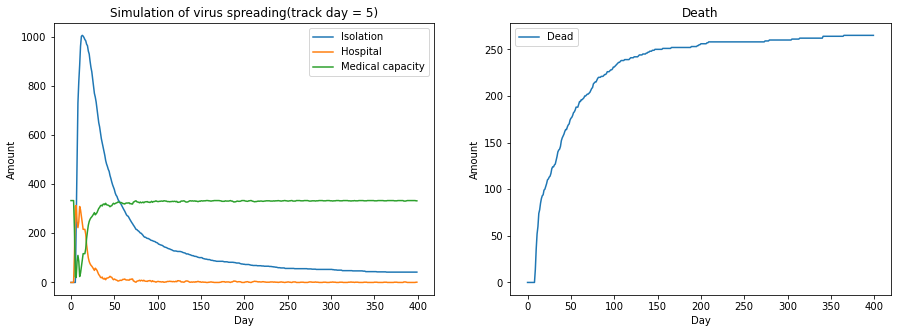

In [15]:
print()
print("Number of false positive = {0}".format(len(model2.false_positive)))
print()

fig,axs = plt.subplots(1,2,figsize = (15,5))
axs[0].plot(range(n_Days), model2.at_isolated, label = "Isolation")
axs[0].plot(range(n_Days), model2.at_hospital, label = "Hospital")
axs[0].plot(range(n_Days), model2.medical_capacity, label = "Medical capacity")


axs[0].set_title("Simulation of virus spreading(track day = {0})".format(track_day))
axs[0].set_xlabel("Day")
axs[0].set_ylabel("Amount")
axs[0].legend()
    


axs[1].plot(range(n_Days), dead, label = "Dead")
axs[1].set_title("Death")
axs[1].set_xlabel("Day")
axs[1].set_ylabel("Amount")
axs[1].legend()
    
plt.show()